In [21]:
import random
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from PIL import Image
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import array_to_img

In [2]:
# Load the test data and models
X_test = np.load('data/preproc_data/X_test.npy')
y_test = np.load('data/preproc_data/y_test.npy')
model_v1 = load_model('model/model_v1.h5')
model_v2 = load_model('model/model_v2.h5')

In [3]:
# Load class_mapping and create reverse mapping
class_mapping = np.load('data/preproc_data/class_mapping.npy', allow_pickle=True).item()
reverse_class_mapping = {i: class_name for class_name, i in class_mapping.items()}

In [4]:
def create_gradcam(img_array, model, layer, pred_index):
    """
    This function creates a Grad-CAM (Gradient-weighted Class Activation Mapping) 
    which is a technique for visualizing the locations in the image that the model 
    considers important for making predictions.

    Args:
        img_array (numpy.ndarray): The input image.
        model (tf.keras.Model): The pre-trained model.
        layer (str): The name of the layer to use for the Grad-CAM.
        pred_index (int): Uses the class with the highest predicted probability.
    """

    # Create a model that returns the activations for the specified layer and the output predictions
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer).output, model.output])

    with tf.GradientTape() as tape:
        layer_output, preds = grad_model(img_array)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Calculate the gradients of the class_channel with respect to the activations of the specified layer
    grads = tape.gradient(class_channel, layer_output)

    # Pool the gradients over all the axes leaving out the channel dimension
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Perform the weighted combination of the feature maps based on the gradients
    heatmap = layer_output @ pooled_grads[..., tf.newaxis]

    # Remove all the dimensions of size 1 from the heatmap
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap such that all values lie in the range [0, 1]
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    return heatmap.numpy()

In [5]:
def overlay_heatmap(heatmap, original_image):
    heatmap = np.uint8(255 * heatmap)
    cmap = plt.colormaps.get_cmap("jet")
    cmap_colors = cmap(np.arange(256))[:, :3]
    cmap_heatmap = cmap_colors[heatmap]

    cmap_heatmap = tf.keras.preprocessing.image.array_to_img(cmap_heatmap)
    cmap_heatmap = cmap_heatmap.resize((original_image.shape[1], original_image.shape[0]))
    cmap_heatmap = tf.keras.preprocessing.image.img_to_array(cmap_heatmap)

    superimposed_img = cmap_heatmap * 0.3 + original_image
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    return superimposed_img

In [6]:
random_indices = random.sample(range(len(X_test)), 20)
reverse_class_mapping = {i: class_name for class_name, i in class_mapping.items()}

IMAGE_SIZE = (224, 224)

In [7]:
models_info = {
    "model_v1": {
        "model": load_model('model/model_v1.h5'),
        "conv_layer": "Convolution-3"
    },
    "model_v2": {
        "model": load_model('model/model_v2.h5'),
        "conv_layer": "Convolution-4"
    }
}

In [10]:
for model_name, model_info in models_info.items():
    model = model_info["model"]
    conv_layer = model_info["conv_layer"]

    correct_dir = f'images/{model_name}/correct_predictions'
    wrong_dir = f'images/{model_name}/wrong_predictions'
    os.makedirs(correct_dir, exist_ok=True)
    os.makedirs(wrong_dir, exist_ok=True)
    
    for idx, i in enumerate(random_indices):
        test_image = X_test[i]
        result = model.predict(np.expand_dims(test_image, axis=0))
        predicted_class_index = np.argmax(result[0])
        predicted_class = reverse_class_mapping[predicted_class_index]
        actual_class_index = np.argmax(y_test[i])
        actual_class = reverse_class_mapping[actual_class_index]
        
        print(f"Predicted: {predicted_class}")
        print(f"Actual: {actual_class}")

        test_image = np.expand_dims(test_image, axis=0)
        heatmap = create_gradcam(test_image, model, conv_layer, predicted_class_index)
        heatmap = cv2.resize(heatmap, (IMAGE_SIZE[1], IMAGE_SIZE[0]))
        test_image_plot = (X_test[i] * 255).astype(np.uint8)
        superimposed_img = overlay_heatmap(heatmap, test_image_plot)
        
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        
        axs[0].imshow(test_image[0])
        axs[0].set_title(f"Actual: {actual_class}\n Predicted: {predicted_class}")
        axs[0].axis('off')

        axs[1].imshow(superimposed_img)
        axs[1].set_title(f"Heatmap")
        axs[1].axis('off')
        
        if predicted_class == actual_class:
            plt.savefig(f"{correct_dir}/correct_pred_{idx}.png")
        else:
            plt.savefig(f"{wrong_dir}/wrong_pred_{idx}.png")
        plt.close(fig)

1/1 [==============================] - 0s 57ms/step
Predicted: speedLimit25
Actual: speedLimit25
1/1 [==============================] - 0s 12ms/step
Predicted: keepRight
Actual: keepRight
1/1 [==============================] - 0s 12ms/step
Predicted: yield
Actual: yield
1/1 [==============================] - 0s 11ms/step
Predicted: speedLimit35
Actual: speedLimit35
1/1 [==============================] - 0s 12ms/step
Predicted: speedLimit25
Actual: speedLimit25
1/1 [==============================] - 0s 12ms/step
Predicted: keepRight
Actual: keepRight
1/1 [==============================] - 0s 13ms/step
Predicted: keepRight
Actual: keepRight
1/1 [==============================] - 0s 12ms/step
Predicted: speedLimit35
Actual: speedLimit35
1/1 [==============================] - 0s 12ms/step
Predicted: speedLimit35
Actual: speedLimit35
1/1 [==============================] - 0s 12ms/step
Predicted: speedLimit35
Actual: speedLimit35
1/1 [==============================] - 0s 12ms/step
Predicted:

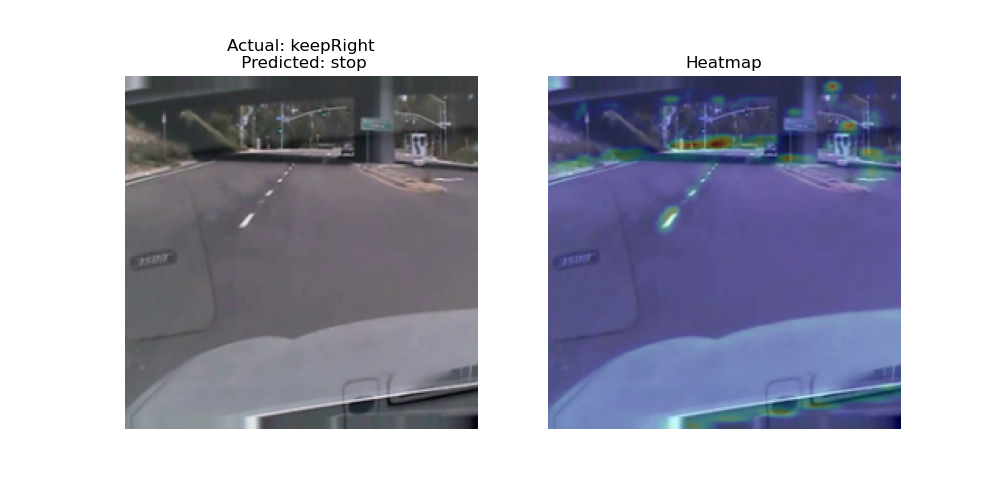

In [25]:
Image.open('images/model_v1/wrong_predictions/wrong_pred_12.png')

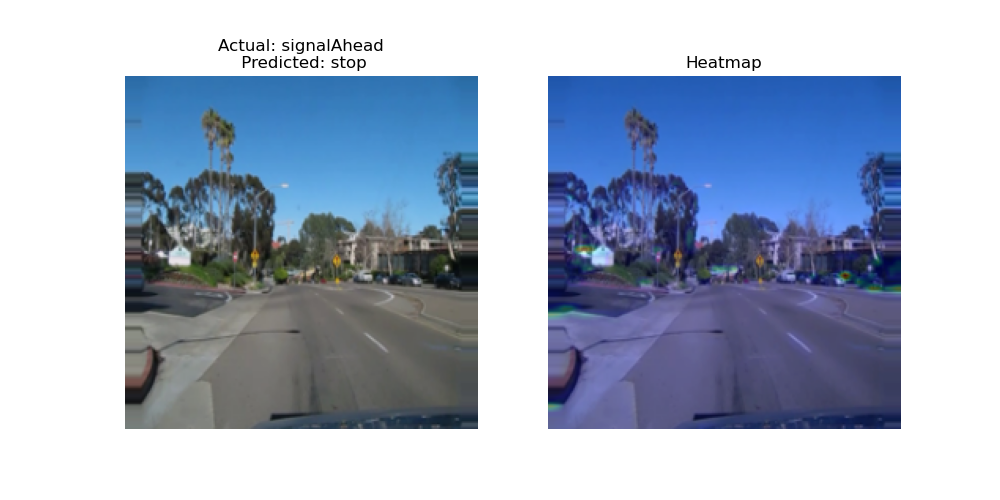

In [26]:
Image.open('images/model_v1/wrong_predictions/wrong_pred_16.png')

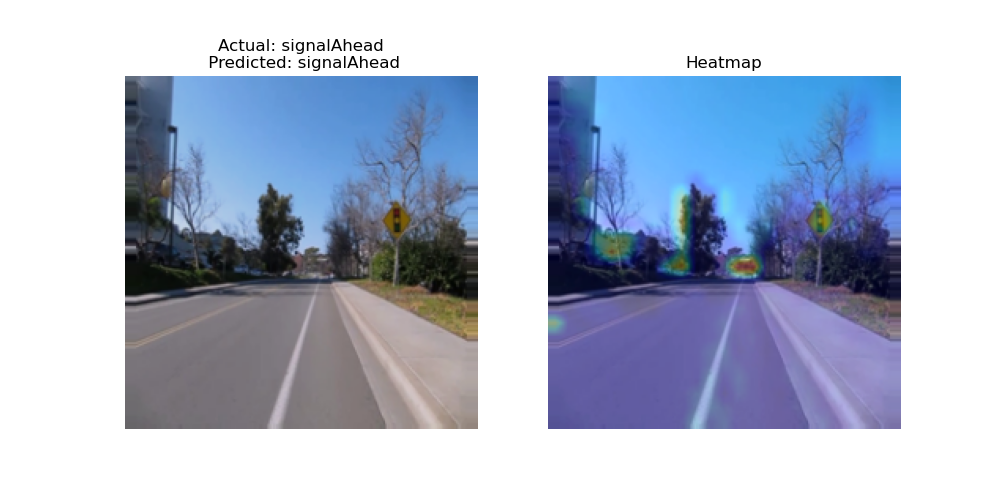

In [27]:
Image.open('images/model_v2/correct_predictions/correct_pred_18.png')

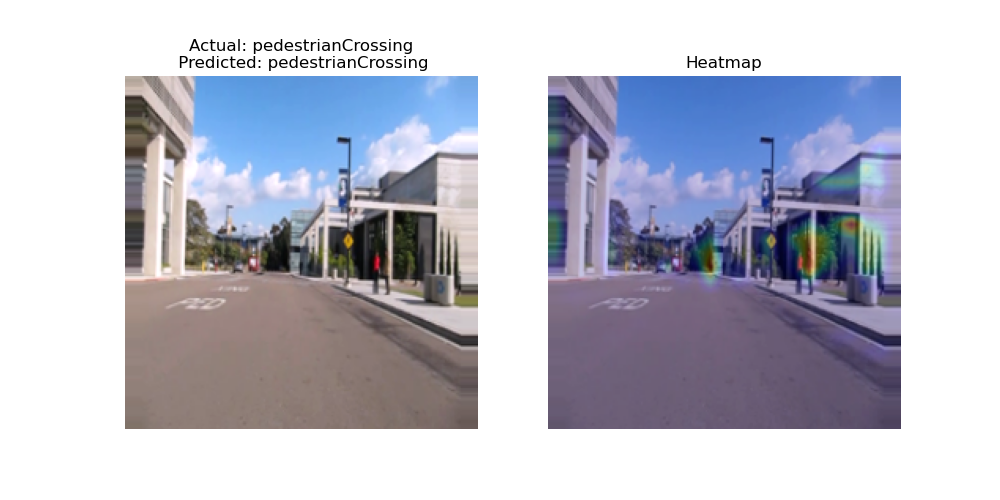

In [28]:
Image.open('images/model_v2/correct_predictions/correct_pred_19.png')

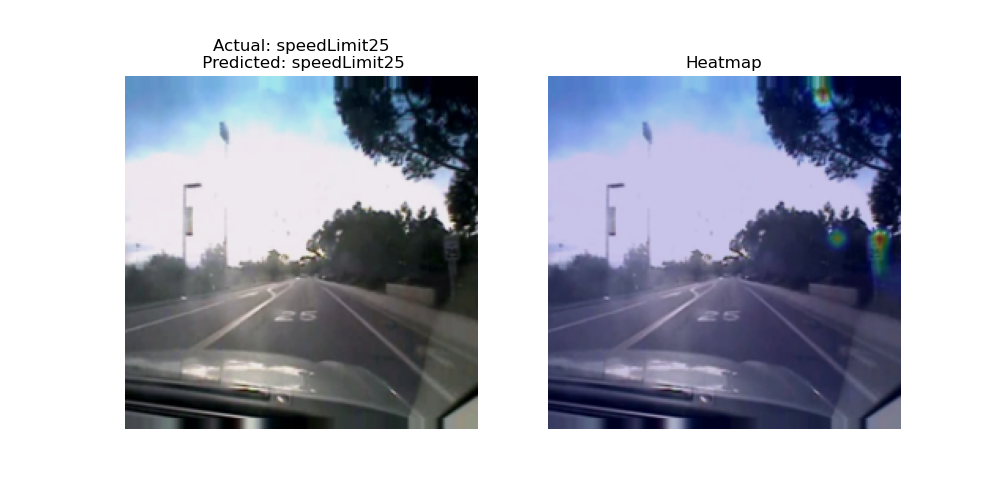

In [29]:
Image.open('images/model_v2/correct_predictions/correct_pred_4.png')